### Data fetching

In [1]:
import xml.etree.ElementTree as ET
train_sources = []
with open("en/truth-train.txt", "r") as f:
    for i in f:
        tmp = i.split(":::")
        tmp[2] = tmp[2][:-1]
        train_sources.append(tmp)
train_tweets = []
for i in train_sources:
    tree = ET.parse("en/"+i[0]+".xml")
    root = tree.getroot()
    for child in root:
        if child.tag == 'documents':
            for tweet in child.findall('document'):
                train_tweets.append((tweet.text,i[2]))


In [2]:
import random

In [3]:
random.shuffle(train_tweets)
test_tweets = train_tweets[int(len(train_tweets)*0.8):]
train_tweets = train_tweets[:int(len(train_tweets)*0.8)]

### calculating average word length

In [4]:
def avg_length(string, count):
    sum_len = 0.
    for i in string.split(" "):
        sum_len += len(i)
    return sum_len/count

### calculating number of stop words

In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stop = stopwords.words('english')
def stops(tweet):
    count = 0.
    for i in tweet:
        if i in stop:
            count += 1
    return count

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### calculating number of special characters

In [6]:
def spec(tweet):
    tmp = "".join(tweet)
    count = 0.
    for i in tmp:
        if i in ["#", "!", "@", "$", "%", "^", "&", "*", "(", ")", "-", "_", "+", "[", "]", ":", "<", ">", "?", "/", "\\", "|"]:
            count+=1
    return count

### calculating number of special digits

In [7]:
def nums(tweet):
    tmp = "".join(tweet)
    count = 0.
    for i in tmp:
        if i in ["1", "2","3", "4", "5", "6", "7", "8", "9", "0"]:
            count+=1
    return count

### calculating number of upper cased words

In [8]:
def upp(tweet):
    count = 0.
    for i in tweet:
        if i.isupper():
            count += 1
    return count


### calculating TF's and IDF's for tf-idf

In [9]:
import numpy as np
def tf(tweet):
    tfs = []
    tweet_words = [i.lower() for i in tweet]
    for i in tweet_words:
        tmp = tweet_words.count(i)
        tfs.append(tmp/len(tweet_words))
    return np.mean(tfs)
                


In [10]:
import numpy as np
def idf(tweet):
    idfs = []
    N = 288000.
    tweet_words = [i.lower() for i in tweet]
    N = len(tweets)
    for i in tweet_words:        
        if i in words_dict:
            idfs.append(np.log(N/words_dict[i]))
        else:
            idfs.append(np.log(N/0.0000001))
    return np.mean(idfs)

### calculating references for other users(very important for bot-human classification)

In [11]:
def refs(tweet):
    tmp = "".join(tweet)
    count = 0.
    for i in tmp:
        if i == "@":
            count+=1
    return count

### calculating number of tweets for each word

In [12]:
words_dict = {}
tweets = [i[0] for i in train_tweets]
for i in range(0, len(tweets)):
    for word in set(tweets[i]):
        word = word.lower()
        if word in words_dict.keys():
            words_dict[word] +=1
        else:
            words_dict[word] = 1
            

###  using CountVectorizer to create 100 features vector for each tweet

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
tweets = [i[0]  for i in train_tweets if i[1]!="bot"]
aims = [0 if i[1] =="female" else 1  for i in train_tweets if i[1]!="bot"]
cv = CountVectorizer(max_df=0.85,stop_words = stop, max_features = 100 )
res = cv.fit_transform(tweets)

# Using Bert


In [17]:
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch

import numpy as np

import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip install torch

In [1]:
import torch
from transformers import *

ModuleNotFoundError: No module named 'torch'

In [ ]:
token_lens = []

for txt in tweets:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

In [18]:
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding(tweets)

In [ ]:
df_train=tweets

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        self.drop = nn.Dropout(p=0.3)

        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask )
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))

model = model.to(device)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

### preparing data to NN's  
### the best results got with such feature list:
#### bot-human: number of words; average word length, number of stop words, number of special characters, number of references and tf-idf (6 features)
#### male-female: number of characters; average word length, number of stop words, number of special characters(5 features) tf-idf doesn't improve accuracy, so it was ommited

In [ ]:
import random
#bot 0 - human 1
train_features1 = []
train_aims1 = []
#female 0 - male 1
train_features2 = []
train_aims2 = []
for i in train_tweets:
    num_of_words = 0. +len(i[0].split(" "))
    num_of_characters = 0. + len(i[0])
    avg_word_length = avg_length(i[0], num_of_words)
    stop_words = stops(i[0])
    special_characters =spec(i[0])
    refers = refs(i[0])
    #numerics = nums(i[0])
    #uppers = upp(i[0])
    
    tfs = tf(i[0])
    idfs = idf(i[0])
    class_id1 = 0
    class_id2 = 0
    if i[1] == 'bot':
        class_id1 = 0
    if i[1] == 'female':
        class_id1 = 1
        class_id2 = 0
    if i[1] == 'male':
        class_id1 = 1
        class_id2 = 1
    train_features1.append([num_of_words,avg_word_length,stop_words,special_characters, refers, tfs*idfs])
    train_aims1.append(class_id1)
    if i[1] != 'bot':
        train_features2.append([num_of_characters,avg_word_length,stop_words,special_characters])
        train_aims2.append(class_id2)
    print(len(train_features1))


### normalization for 3 prepared data sets:
#### norm res - 100 features using CountVectorizer for male-female 
#### normalized_features1- bot-human
#### normalized_features2- male-female

In [17]:
#normalization
from sklearn import preprocessing
norm_res =preprocessing.normalize(res,norm='l2',axis=1,copy=True)
normalized_features1 =preprocessing.normalize(train_features1,norm='l2',axis=1,copy=True)
normalized_features2 =preprocessing.normalize(train_features2,norm='l2',axis=1,copy=True)

## Data visualization

In [18]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs



### using PCA(SVD) for dimentions reduction to show our data on graphics 
#### we can choose whether show normalized data or not
##### for bot-human

In [19]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(2)

In [20]:
transformed = svd.fit_transform(normalized_features1)

In [21]:
transformed = svd.fit_transform(train_features1)

In [22]:
bot_X = []
bot_Y = []
human_X = []
human_Y = []
for i in range (0,len(transformed)):
    if train_aims1[i] == 0:
        bot_X.append(transformed[i][0])
        bot_Y.append(transformed[i][1])
    else:
        human_X.append(transformed[i][0])
        human_Y.append(transformed[i][1])

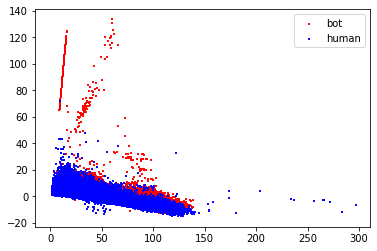

In [23]:

plt.scatter(bot_X, bot_Y, label='bot', c='red',marker = ',',s=1)
plt.scatter(human_X, human_Y, label='human', c='blue', marker = ',',s=1)
matplotlib.pyplot.autoscale(enable=True, axis='both', tight=None)
plt.legend()
plt.show()


##### the same for male-female data

In [24]:
transformed2 = pca.fit_transform(normalized_features2)

In [25]:
transformed2 = svd.fit_transform(train_features2)

In [26]:
female_X = []
female_Y = []
male_X = []
male_Y = []
for i in range (0,len(transformed2)):
    if train_aims2[i] == 0:
        female_X.append(transformed2[i][0])
        female_Y.append(transformed2[i][1])
    else:
        male_X.append(transformed2[i][0])
        male_Y.append(transformed2[i][1])

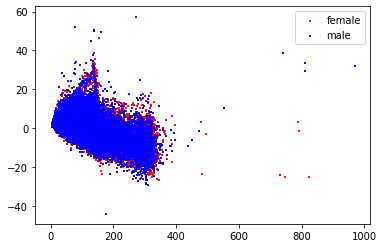

In [27]:
plt.scatter(female_X, female_Y, label='female', c='red',marker = ',',s=1)
plt.scatter(male_X, male_Y, label='male', c='blue', marker = ',',s=1)
matplotlib.pyplot.autoscale(enable=True, axis='both', tight=None)
plt.legend()
plt.show()

### for male-female with 100 features

In [28]:
transformed3 = svd.fit_transform(res)

In [29]:
transformed3 = svd.fit_transform(norm_res)


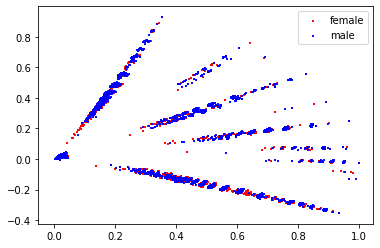

In [30]:
female_X = []
female_Y = []
male_X = []
male_Y = []
for i in range (0,len(transformed3)):
    if aims[i] == 0:
        female_X.append(transformed3[i][0])
        female_Y.append(transformed3[i][1])
    else:
        male_X.append(transformed3[i][0])
        male_Y.append(transformed3[i][1])
plt.scatter(female_X, female_Y, label='female', c='red',marker = ',',s=1)
plt.scatter(male_X, male_Y, label='male', c='blue', marker = ',',s=1)
matplotlib.pyplot.autoscale(enable=True, axis='both', tight=None)
plt.legend()
plt.show()

### preparing target arrays for NN to receive n(number of records)x2(number of our classes) shape

In [33]:
!pip install tensorflow

Processing c:\users\anna\appdata\local\pip\cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6\termcolor-1.1.0-cp37-none-any.whl
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121935 sha256=b62cbf32a6ae515fc758d370dfaf29ffb609dc5ab00ae6df34e91111c2b58466
  Stored in directory: c:\users\anna\appdata\local\pip\cache\wheels\cc\af\1a\498a24d0730ef484019e007bb9e8cef3ac00311a672c049a3e
Successfully built absl-py
  Attempting uninstall: h5py
    Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:
      Successfully uninstalled h5py-2.9.0


ERROR: keras 2.2.4 requires keras-applications>=1.0.6, which is not installed.
ERROR: tensorflow-probability 0.8.0 has requirement gast<0.3,>=0.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: deeppavlov 0.6.0 has requirement h5py==2.9.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: deeppavlov 0.6.0 has requirement numpy==1.16.4, but you'll have numpy 1.18.1 which is incompatible.
ERROR: deeppavlov 0.6.0 has requirement pyopenssl==19.0.0, but you'll have pyopenssl 19.1.0 which is incompatible.
ERROR: deeppavlov 0.6.0 has requirement scipy==1.3.0, but you'll have scipy 1.4.1 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\anna\\appdata\\roaming\\python\\python37\\site-packages\\~5py\\defs.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [35]:
import numpy as np
from keras.utils import to_categorical

train_aims1 = np.asarray(train_aims1)
train_aims1.reshape(-1,1)
train_labels1 = to_categorical(train_aims1)

train_aims2 = np.asarray(train_aims2)
train_aims2.reshape(-1,1)

train_labels2 = to_categorical(train_aims2)

aims = to_categorical(aims)


Using TensorFlow backend.
C:\Users\Anna\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anna\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anna\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anna\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

### 3 models are prepared:
#### 1: bot-human used sequential
#### 2: male-female used sequential
#### 3: male-female used reccurrent
#### 4: male-female used sequential

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import to_categorical 





model1 = Sequential()
model1.add(Dense(6, activation='relu', input_dim=6))
model1.add(Dense(5, activation='relu'))
model1.add(Dense(3, activation='relu'))
model1.add(Dense(2, activation='softmax'))

model1.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model2 = Sequential()
model2.add(Dense(4, activation='relu', input_dim=4))
model2.add(Dense(3, activation='relu'))
model2.add(Dense(2, activation='softmax'))

model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model3 = Sequential()
model3.add(LSTM(100,input_shape=(1, 100), activation='relu', return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(100, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(2, activation='softmax'))
model3.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


model4 = Sequential()
model4.add(Dense(100, activation='relu', input_dim=100))
model4.add(Dense(1000, activation='relu'))
model4.add(Dense(1000, activation='relu'))
model4.add(Dense(100, activation='relu'))
model4.add(Dense(2, activation='softmax'))

model4.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### using pickle, prepared data was saved to show working NN faster

In [37]:
import pickle
#pickle.dump( normalized_features1, open( "normalized_features1.p", "wb" ) )
#pickle.dump( train_labels1, open( "train_labels1.p", "wb" ) )
#normalized_features1 = pickle.load( open( "normalized_features1.p", "rb" ) )
#train_labels1 = pickle.load( open( "train_labels1.p", "rb" ) )
#pickle.dump( normalized_features2, open( "normalized_features2.p", "wb" ) )
#pickle.dump( train_labels2, open( "train_labels2.p", "wb" ) )
#normalized_features2 = pickle.load( open( "normalized_features2.p", "rb" ) )
#train_labels2 = pickle.load( open( "train_labels2.p", "rb" ) )
#pickle.dump( norm_res, open( "norm_res.p", "wb" ) )
#pickle.dump( aims, open( "aims.p", "wb" ) )
#norm_res = pickle.load( open( "norm_res.p", "rb" ) )
#aims = pickle.load( open( "aims.p", "rb" ) )

In [38]:
try:
    model1.fit(normalized_features1, train_labels1, epochs=3)
except KeyboardInterrupt:
    pass

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/3
230400/230400 [==============================] - 35s 151us/step - loss: 0.5031 - acc: 0.7785
Epoch 2/3
230400/230400 [==============================] - 38s 165us/step - loss: 0.4631 - acc: 0.8045
Epoch 3/3
230400/230400 [==============================] - 31s 135us/step - loss: 0.4611 - acc: 0.8043


In [39]:
try:
    model2.fit(normalized_features2, train_labels2, epochs=3)
except KeyboardInterrupt:
    pass

Epoch 1/3
115345/115345 [==============================] - 18s 153us/step - loss: 0.6921 - acc: 0.5224
Epoch 2/3
115345/115345 [==============================] - 14s 122us/step - loss: 0.6883 - acc: 0.5495
Epoch 3/3
115345/115345 [==============================] - 14s 120us/step - loss: 0.6860 - acc: 0.5543


### the results of model3 and model4 should be similar, because actually we don't have any time series using such dataset
### It can be possibly improved by using n-gramms. using series of n-grams as time series and using features from n-grams such as emmision probabilities, transition probabilities etc.

In [40]:
reshaped_norm_res = norm_res.toarray()
reshaped_norm_res = reshaped_norm_res.reshape(len(reshaped_norm_res),1, 100)

In [41]:
try:
    model3.fit(reshaped_norm_res, aims, epochs=3)
except KeyboardInterrupt:
    pass

Epoch 1/3
115345/115345 [==============================] - 125s 1ms/step - loss: 0.6627 - acc: 0.6006 0s - loss: 0.6628 - acc: 
Epoch 2/3
115345/115345 [==============================] - 82s 708us/step - loss: 0.6554 - acc: 0.60791s - lo
Epoch 3/3
115345/115345 [==============================] - 96s 832us/step - loss: 0.6530 - acc: 0.6103


In [42]:
try:
    model4.fit(norm_res, aims, epochs=3)
except KeyboardInterrupt:
    pass

Epoch 1/3
115345/115345 [==============================] - 550s 5ms/step - loss: 0.6616 - acc: 0.6025
Epoch 2/3
115345/115345 [==============================] - 342s 3ms/step - loss: 0.6530 - acc: 0.6098
Epoch 3/3
115345/115345 [==============================] - 305s 3ms/step - loss: 0.6489 - acc: 0.6123


# Testing

In [43]:
import random
#bot 0 - human 1
test_features1 = []
test_aims1 = []
#female 0 - male 1
test_features2 = []
test_aims2 = []
random.shuffle(test_tweets)
for i in test_tweets:
    num_of_words = 0. +len(i[0].split(" "))
    num_of_characters = 0. + len(i[0])
    avg_word_length = avg_length(i[0], num_of_words)
    stop_words = stops(i[0])
    special_characters =spec(i[0])
    refers = refs(i[0])
    #numerics = nums(i[0])
    #uppers = upp(i[0])
    
    tfs = tf(i[0])
    idfs = idf(i[0])
    class_id1 = 0
    class_id2 = 0
    if i[1] == 'bot':
        class_id1 = 0
    if i[1] == 'female':
        class_id1 = 1
        class_id2 = 0
    if i[1] == 'male':
        class_id1 = 1
        class_id2 = 1
    test_features1.append([num_of_words,avg_word_length,stop_words,special_characters, refers, tfs*idfs])
    test_aims1.append(class_id1)
    if i[1] != 'bot':
        test_features2.append([num_of_characters,avg_word_length,stop_words,special_characters])
        test_aims2.append(class_id2)


In [44]:
tweetstest = [i[0]  for i in test_tweets if i[1]!="bot"]
aimstest = [0 if i[1] =="female" else 1  for i in test_tweets if i[1]!="bot"]
cv = CountVectorizer(max_df=0.85,stop_words = stop, max_features = 100 )
restest = cv.fit_transform(tweetstest)

In [45]:
norm_restest =preprocessing.normalize(restest,norm='l2',axis=1,copy=True)
normalized_features1test =preprocessing.normalize(test_features1,norm='l2',axis=1,copy=True)
normalized_features2test =preprocessing.normalize(test_features2,norm='l2',axis=1,copy=True)

In [46]:
res = []
for index, i in enumerate(normalized_features1test):
    a = np.array(i)
    a =a.reshape(1,-1)

    res.append(model1.predict_classes(a))


In [47]:
acc = 0.
for index, i in enumerate(res):
    if (i[0] == 0 and test_aims1[index]==0) or (i[0] == 1 and test_aims1[index]==1):
        acc+=1.

print("Accuracy for test set on model1: ", acc/len(res))

Accuracy for test set on model1:  0.8050347222222223


In [48]:
res = []
for index, i in enumerate(normalized_features2test):
    a = np.array(i)
    a =a.reshape(1,-1)

    res.append(model2.predict_classes(a))


In [49]:
acc = 0.
for index, i in enumerate(res):
    if (i[0] == 0 and test_aims2[index]==0) or (i[0] == 1 and test_aims2[index]==1):
        acc+=1.

print("Accuracy for test set on model2: ", acc/len(res))

Accuracy for test set on model2:  0.5537602512650497


In [50]:

reshaped_norm_res_test = norm_restest.toarray()
reshaped_norm_res_test = reshaped_norm_res_test.reshape(len(reshaped_norm_res_test),1, 100)

In [51]:
res = []
res.append(model3.predict_classes(reshaped_norm_res_test))

In [52]:
acc = 0.
for index, i in enumerate(res[0]):
    if (i == 0 and aimstest[index]==0) or (i == 1 and aimstest[index]==1):
        acc+=1.

print("Accuracy for test set on model3: ", acc/len(res[0]))

Accuracy for test set on model3:  0.5553306578258593


In [53]:
res = []
for index, i in enumerate(norm_restest):
    res.append(model4.predict_classes(i))

In [54]:
acc = 0.
for index, i in enumerate(res):
    if (i[0] == 0 and aimstest[index]==0) or (i[0] == 1 and aimstest[index]==1):
        acc+=1.

print("Accuracy for test set on model4: ", acc/len(res))

Accuracy for test set on model4:  0.5499214796719595
